In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_corrections
import requests

In [2]:
release=None

In [32]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-25,2021-01-24,United Kingdom,K02000001,NaN,NaN,154.0,412204.0
1,2021-01-25,2021-01-23,United Kingdom,K02000001,17796.0,NaN,402.0,484485.0
2,2021-01-25,2021-01-22,United Kingdom,K02000001,28114.0,NaN,657.0,629416.0
3,2021-01-25,2021-01-21,United Kingdom,K02000001,30963.0,3547.0,927.0,665330.0
4,2021-01-25,2021-01-20,United Kingdom,K02000001,34788.0,4014.0,1039.0,640856.0
...,...,...,...,...,...,...,...,...
356,2021-01-25,2020-02-03,United Kingdom,K02000001,0.0,NaN,NaN,NaN
357,2021-01-25,2020-02-02,United Kingdom,K02000001,0.0,NaN,NaN,NaN
358,2021-01-25,2020-02-01,United Kingdom,K02000001,2.0,NaN,NaN,NaN
359,2021-01-25,2020-01-31,United Kingdom,K02000001,1.0,NaN,NaN,NaN


In [33]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-25.csv')

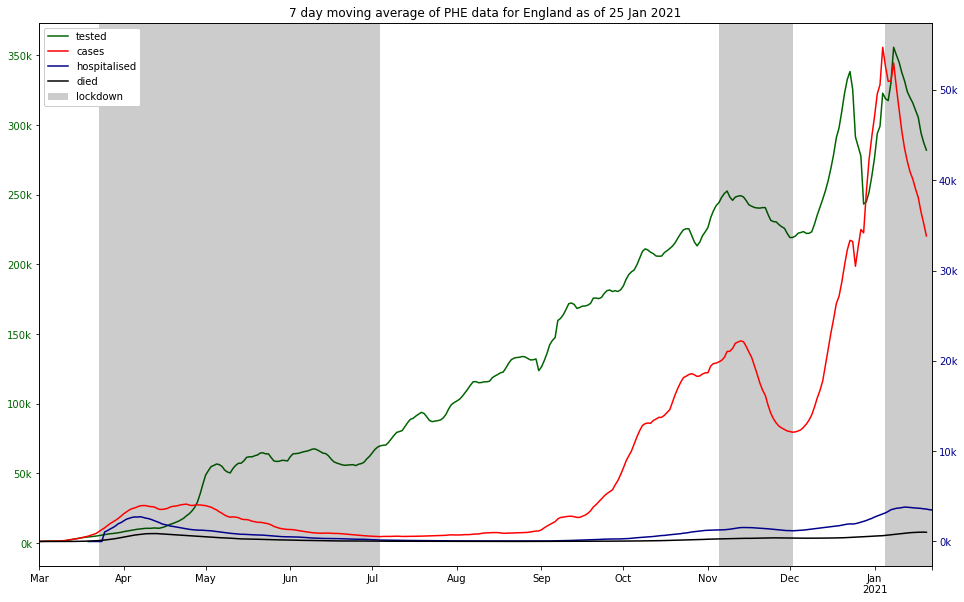

In [34]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [35]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-25.csv')

In [36]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-25.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,23460.0,159642.0,136182.0,1893667,1.238866,7.191444,91.569690
1,Scotland,S92000003,5538.0,415402.0,409864.0,5463300,0.101367,7.502132,92.396500
2,Wales,W92000004,543.0,270833.0,270290.0,3152879,0.017222,8.572800,91.409978
3,England,E92000001,441684.0,5727693.0,5286009.0,56286961,0.784700,9.391179,89.824121


'6,573,570'

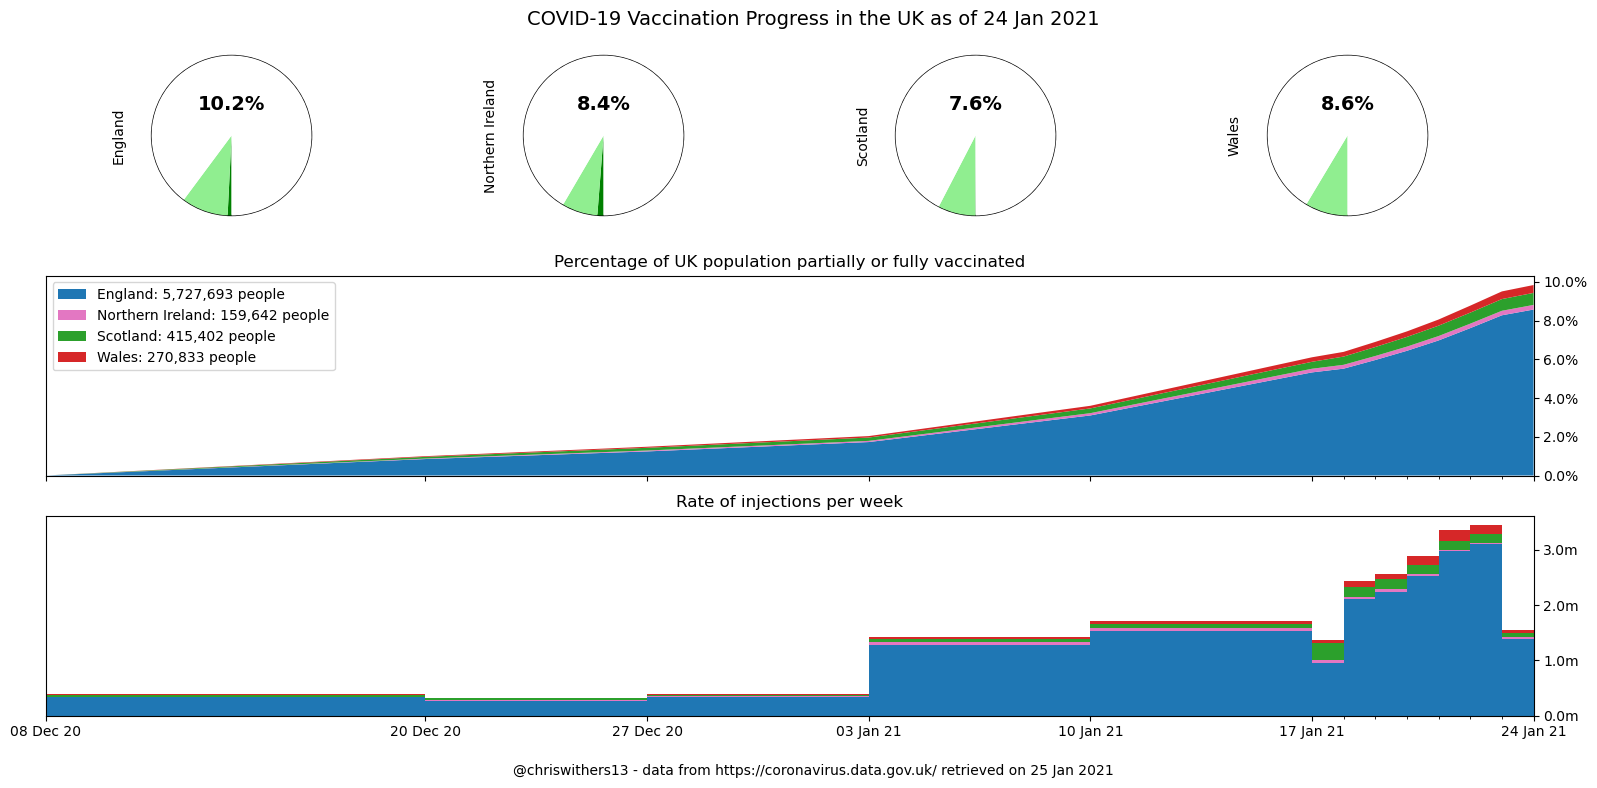

In [3]:
results = vaccination_dashboard()
display(results)
f"{results['any'].sum():,.0f}"

In [4]:
vaccination_corrections()

In [38]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-25.csv')

In [39]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-25.csv')

In [40]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-25.csv')

In [41]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-25, release: 2021-01-25 16:00:03.076378+00:00, msoa: 2021-01-25 16:19:06+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-25.csv')